# Synthetic Cluster Generation Tutorial Part 2: cluster  member emulator

Owner: **Tamas Norbert Varga** @vargatn

This notebook relies on one external package in addition to the default desc kernels on NERSC


This notebook will describe how to set up, run and postprocess the cluster line-of-sight emulation with the skysampler package. The settings are adapted to DC2 and DESC data products, see Part 1 of the tutorial.


**Objectives:**

    * Load and collate galaxy catalogs 
    * Set up cluster line-of-sight emulation script
    * INTENSIVE Draw samples from the proposal galaxy catalog and calculate survival scores for rejection sampling.
    * Define KDE model for cluster member galaxy features
    * Visualize model against simulations

Logistics: This notebook is intended to be be run with a python 3 installation of the skysampler package https://github.com/vargatn/skysampler/tree/lsst-dev  

Other notes:

    Some calculations in this notebook are time consuming, and are optimized for a HPC environment other than NERSC. These cells are currently commented out.
    
Output:

    The results of this notebook are made available on NERSC at /global/cscratch1/sd/tvarga/DC_DATA/


In [22]:
import fitsio as fio
import numpy as np
import pandas as pd

import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import matplotlib as mpl
import subprocess as sp

import scipy.interpolate as interpolate
import pickle as pickle

import multiprocessing as mp


# this package is installed from https://github.com/vargatn/skysampler/tree/lsst-dev  
import skysampler_lsst.emulator as emulator
import skysampler_lsst.utils as utils
from skysampler_lsst.reader import result_reader

## Data paths
 These will vary upon your server data locations, change them accordingly

 Paths for data preparations

In [2]:
# redmapper catalog paths
redmapper_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_redmapper_v0.7.5_clust.h5"

# cutout paths string
cutout_fname_base = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/dc2_cluster_sim_cutouts/clust-{}_dc2-sim-cutout.h5"
# cutout output name
cutout_oname = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/dc2_cluster_sim_cutouts/clust_dc2-sim-LOS_v1.h5"

# reference pixel filename input
fname_refpixel = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_refpixel-{}.h5"
# reference pixel filename output
oname_refpixel = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_refpixels.h5"



Path for resampling calculations

In [3]:
# paths for calculations
root_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/resamples/"
deep_data_path = oname_refpixel
wide_data_path = cutout_oname

In [4]:
tag_root = "dc2-alpha_concentric_sample-v01_test-03" # this is what the current output files will be saved as

 # Data Preparation

## Concatenate cluster catalog cutouts

We are concatenating the galaxy catalog cutouts around clusters. These are initially saved in a separate file for each cluster. For further processing these are saved again in a single file

In [5]:
clusters = pd.read_hdf(redmapper_path, key="data")

In [6]:
ii = (clusters["richness"] > 30) & (clusters["richness"] < 60) & (clusters["redshift"] > 0.3) & (clusters["redshift"] < 0.35)
ii.sum()

41

Note that above we restricts the redshift range to 0.3 - 0.35. This is done as the emulated clusters will be representative of the ensemble properties of the selection. A narrow redshift range minimizes the intrinsic spread in apparent photometry properties.

There are 41 clusters in this selection


In [7]:
# table = []
# for cid in clusters[ii]["cluster_id"]:
#     print(cid)
#     fname = cutout_fname_base.format(cid)
#     tab = pd.read_hdf(fname, key="data")
#     tab["cluster_id"] = cid
#     tab = tab[tab["R"] < 16 ]
#     table.append(tab)
# table = pd.concat(table)
# table.to_hdf(cutout_oname, key="data")

## reference field data

Since we saved all galaxies from three randomly selected healpix pixels, we are now concatenating them for further processing

In [8]:
# pixels = [8786, 8791, 9937]
# refpixel = []
# for pix in pixels:
#     print(pix)
#     tmp = pd.read_hdf(fname_refpixel.format(pix), key="data")
#     refpixel.append(tmp)
# refpixel = pd.concat(refpixel)

In [9]:
# refpixel["R"] = np.sqrt(np.random.uniform(0, 16**2., size=len(refpixel)))

We assign a mock uniform radial profile to reference field galaxies. In case of availability, this can be replaced by the radial profile around random points (such as redmapper randoms). That approach is bit more advanced, and captures the un-evennes and edges in the survey footprint

In [10]:
# refpixel.to_hdf(oname_refpixel, key="data")

# Train KDE model and calculate survival scores

In [11]:
NREPEATS = 4 # number of times the full run is repeated
NSAMPLES = 1600000 # number of propsal samples to draw
NCHUNKS = 160 # number of CPU cores to use
bandwidth=0.1 # Gaussian KDE bandwidth in the eigen-feature space after applying PCA

# data paths, the code will create a subfolder within root_path based on tag_root

# The number of galaxies goes with surface area element, to avoid modeling very un-balanced PDFs 
# a series of nested concentric segments are modeled consecutively and later stiched together
LOGR_DRAW_RMINS = np.array([-3, -0.5, 0., 0.5])
LOGR_DRAW_RMAXS = np.array([-0.5, 0., 0.5, 1.2])
LOGR_CAT_RMAXS = [0., 0.5, 1.1, 1.2]

# feature aliases and definitions from the deep / reference dataset for comparison with the wide dataset
deep_c_settings = {
    "columns": [
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
    ],
    "logs": [False, False, False, False],
    "limits": [(17, 22.5), (-1, 3), (-1, 3), (-1, 3)],
}

# feature aliases and definitions for all features we want to model and inherit from the deep / reference fields
deep_smc_settings = {
    "columns": [
        ("GABS", ("ellipticity_1_true", "ellipticity_2_true", "SQSUM")),
        ("SIZE", "size_true"),
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
        ("COLOR_I_Z", ("mag_i", "mag_z", "-")),
        ("STELLAR_MASS", "stellar_mass"),
        ("HALO_MASS", "halo_mass")
    ],
    "logs": [False, True, False, False, False, False, True, True],
    "limits": [(0., 1.), (-1, 5), (17, 25), (-1, 3), (-1, 3), (-1, 3), (10**3, 10**13), (10**9, 10**16)],
}

# feature aliases and definitions from wide dataset
wide_cr_settings = {
    "columns": [
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
        ("LOGR", "R"),
    ],
    "logs": [False, False, False, True],
    "limits": [(17, 22.5), (-1, 3), (-1, 3), (1e-3, 16.), ],
}

# the radial profile around clusters from the wide dataset
wide_r_settings = {
    "columns": [
        ("MAG_I", "mag_i"),
        ("LOGR", "R"),
    ],
    "logs": [False, True,],
    "limits": [(17, 22.5), (1e-3, 16.),],
}
# features to use for rejection sampling
columns = {
    "cols_dc": ["COLOR_G_R", "COLOR_R_I",],
    "cols_wr": ["LOGR",],
    "cols_wcr": ["COLOR_G_R", "COLOR_R_I", "LOGR",],
}

The below script carries out most heavy lifting calculation

1) loading the data

2) constructs the features from the above dictionaries

3) transforms features into their eigien-space and builds a KDE

4) draws NSAMPLES proposal points from the features in  deep_smc_settings 

5) scores each proposal point based on the KDE models of the other features. (scores are transformed according to PCA jacobian for each feature space)

6) saves samples, scores, and jacobian for each draw

This section is commented out as it takes a ~few hunderd CPU hours to run and it's not optimized for NERSC job managers. Currently it was ran in a local computing resource at LMU Munich.

The results of the calculation are made available on NERSC, so feel free to skip to the next sections.

In [12]:
# print("started reading")
# refpixel = pd.read_hdf(deep_data_path, key="data")
# table = pd.read_hdf(wide_data_path, key="data")

# print("creating output folder")
# root_path = root_path + tag_root + "/"
# print(root_path)
# if not os.path.isdir(root_path):
#     os.mkdir(root_path)

# nrbins = len(LOGR_DRAW_RMINS)
# print("NRBINS:", nrbins)

# for nrep in np.arange(NREPEATS):
#     tag = tag_root + "_run" + str(nrep)
#     print("running repeat", nrep, "out of", NREPEATS)
#     print(tag)

#     master_seed = np.random.randint(0, np.iinfo(np.int32).max, 1)[0]
#     rng = np.random.RandomState(seed=master_seed)
#     seeds = rng.randint(0, np.iinfo(np.int32).max, nrbins * 5)

#     i = 0
#     print("starting concentric shell resampling")
#     for i in np.arange(nrbins):
#         print("rbin", i)
#         outname = root_path + "/" + tag + "_{:1d}".format(master_seed) + "_rbin{:d}".format(i)
#         print(outname)

#         # loading random data
#         tmp_wide_r_settings = wide_r_settings.copy()
#         tmp_wide_r_settings["limits"][-1] = (10**-3, 10**LOGR_CAT_RMAXS[i])
#         _wide_r_settings_rands = emulator.construct_deep_container(refpixel, tmp_wide_r_settings, seed=seeds[nrbins * i + 0], drop="MAG_I")

#         tmp_wide_cr_settings = wide_cr_settings.copy()
#         tmp_wide_cr_settings["limits"][-1] = (10**-3, 10**LOGR_CAT_RMAXS[i])
#         _wide_cr_settings_rands = emulator.construct_deep_container(refpixel, tmp_wide_cr_settings, seed=seeds[nrbins * i + 1], drop="MAG_I")

#         # loading deep catalogs
#         _deep_c_settings = emulator.construct_deep_container(refpixel, deep_c_settings, seed=seeds[nrbins * i + 2], drop="MAG_I")
#         _deep_smc_settings = emulator.construct_deep_container(refpixel, deep_smc_settings, seed=seeds[nrbins * i + 3])

#         # loading cluster data
#         tmp_wide_cr_settings = wide_cr_settings.copy()
#         tmp_wide_cr_settings["limits"][-1] = (10**-3, 10**LOGR_CAT_RMAXS[i])
#         _wide_cr_settings_clust = emulator.construct_deep_container(table, tmp_wide_cr_settings, seed=seeds[nrbins * i + 4], drop="MAG_I")

#         infodicts, samples = emulator.make_classifier_infodicts(_wide_cr_settings_clust, _wide_r_settings_rands,
#                                                                 _wide_cr_settings_rands,
#                                                                 _deep_c_settings, _deep_smc_settings,
#                                                                 columns, nsamples=NSAMPLES, nchunks=NCHUNKS,
#                                                                 bandwidth=bandwidth,
#                                                                 rmin=LOGR_DRAW_RMINS[i],
#                                                                 rmax=LOGR_DRAW_RMAXS[i])

#         fname = outname + "_samples.fits"
#         print(fname)
#         fio.write(fname, samples.to_records(), clobber=True)
#         master_dict = {
#             "columns": infodicts[0]["columns"],
#             "bandwidth": infodicts[0]["bandwidth"],
#             "deep_c_settings": deep_c_settings,
#             "deep_smc_settings": deep_smc_settings,
#             "wide_r_settings": tmp_wide_r_settings,
#             "wide_cr_settings": tmp_wide_cr_settings,
#             "rmin": infodicts[0]["rmin"],
#             "rmax": infodicts[0]["rmin"],
#         }
#         pickle.dump(master_dict, open(outname + ".p", "wb"))
#         print("calculating scores")
#         result = emulator.run_scores2(infodicts)
#         print("finished calculating scores")
#         fname = outname + "_scores.fits"
#         print(fname)
#         fio.write(fname, result.to_records(), clobber=True)


# Posprocess  rejection sampling results

The below settings are mostly identical to the previous section.

Since we are working in DC2, we have access to all features in the deep / reference data also around clusters, so we modify that feature list to include everything

*The below settings define the **reference dataset** for convinience, and are slightly different from the ones in the previous sections*

In [14]:
NREPEATS = 4
NSAMPLES = 1600000
NCHUNKS = 160
bandwidth=0.1

LOGR_DRAW_RMINS = np.array([-3, -0.5, 0., 0.5])
LOGR_DRAW_RMAXS = np.array([-0.5, 0., 0.5, 1.2])
LOGR_CAT_RMAXS = [0., 0.5, 1.1, 1.2]

deep_smc_settings = {
    "columns": [
        ("GABS", ("ellipticity_1_true", "ellipticity_2_true", "SQSUM")),
        ("SIZE", "size_true"),
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
        ("COLOR_I_Z", ("mag_i", "mag_z", "-")),
        ("STELLAR_MASS", "stellar_mass"),
        ("HALO_MASS", "halo_mass")        
    ],
    "logs": [False, True, False, False, False, False, True, True],
    "limits": [(0., 1.), (-1, 5), (17, 25), (-1, 3), (-1, 3), (-1, 3), (10**3, 10**13), (10**9, 10**16)],
}

# this is just a copy of the deep_smc_settings, in DC2 we have access to this information
wide_cr_settings = {
    "columns": [
        ("GABS", ("ellipticity_1_true", "ellipticity_2_true", "SQSUM")),
        ("SIZE", "size_true"),
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
        ("COLOR_I_Z", ("mag_i", "mag_z", "-")),
        ("STELLAR_MASS", "stellar_mass"),
        ("HALO_MASS", "halo_mass"),
        ("LOGR", "R"),        
    ],
    "logs": [False, True, False, False, False, False, True, True, True],
    "limits": [(0., 1.), (-1, 5), (17, 25), (-1, 3), (-1, 3), (-1, 3), (10**3, 10**13), (10**9, 10**16), (1e-3, 16)],
}

columns = {
    "cols_dc": ["COLOR_G_R", "COLOR_R_I",],
    "cols_wr": ["LOGR",],
    "cols_wcr": ["COLOR_G_R", "COLOR_R_I", "LOGR",],
}

 loading a bunch of data files, this part is a bit redundant, but if you did not execute the previous section then you have to load them here

In [15]:
refpixel = pd.read_hdf(deep_data_path, key="data")
table = pd.read_hdf(wide_data_path, key="data")

In [16]:

tmp_wide_cr_settings = wide_cr_settings.copy()
_wide_cr_settings_rands = emulator.construct_deep_container(refpixel, tmp_wide_cr_settings)

# loading deep catalogs
_deep_smc_settings = emulator.construct_deep_container(refpixel, deep_smc_settings)

# loading cluster data
tmp_wide_cr_settings = wide_cr_settings.copy()
_wide_cr_settings_clust = emulator.construct_deep_container(table, tmp_wide_cr_settings)

(1513572, 9)
(1513572,)
(1513572, 8)
(1513572,)
(1009658, 9)
(1009658,)


Loop over the files which contain the proposed galaxy draws, and the corresponding acceptance scores

In [17]:
samples = []
scores = []
for rbin in np.arange(4):
    print(rbin)
#     expr = "/e/ocean1/users/vargatn/EMULATOR/EPSILON/resamples/epsilon_concentric_sample_v06_run*_rbin" + str(rbin) + "*samples.fits" 
    expr = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/resamples/dc2-alpha_concentric_sample-v01_test-03/dc2-alpha_concentric_sample-v01_test-03_run0*_rbin" + str(rbin) + "*samples.fits" 

    fnames_samples = np.sort(glob.glob(expr))
    fnames_scores = []
    for fname in fnames_samples:
        fnames_scores.append(fname.replace("samples.fits", "scores.fits"))

    samples_sep = []
    scores_sep = []
    for i, fname in enumerate(fnames_samples):
#         print(fname)
        samples_sep.append(fio.read(fname))
        scores_sep.append(fio.read(fnames_scores[i]))
        
    samples.append(np.hstack(samples_sep))
    scores.append(np.hstack(scores_sep))

0
1
2
3


In [20]:
mag_lims = (17, 22.5)
r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]
redges = [-1.5, -0.5, 0., 0.5, 1.0]
rareas = np.array([np.pi*((10**redges[i+1])**2. - (10**redges[i])**2.) for i in np.arange(len(redges)-1)])

In [23]:
# Calculate the observed surface density of **bright** fields galaxies, 
# this will anchor our expectation about the full galaxy distribution

magcol = "mag_i"
ii = ((table[magcol] > mag_lims[0]) & (table[magcol] < mag_lims[1]))

clust_los_nums = np.histogram(np.log10(table[ii]["R"]), bins=redges)[0] / 41 # / nc

ii = ((refpixel[magcol] > mag_lims[0]) & (refpixel[magcol] < mag_lims[1]))
surfdens = len(refpixel[ii]) / hp.nside2pixarea(32, degrees=True) / 3600 / 3
rands_los_nums = surfdens * rareas
# rands_los_nums = np.histogram(np.log10(refpixel[ii]["R"]), bins=redges)[0] / rareas#* ratio# / nr
nratios = clust_los_nums / rands_los_nums

/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
ifields2 = []
iclusts2 = []
i2ds2 = []
for rbin in np.arange(4):
    print(rbin)
    _ifield, _iclust, _i2d = result_reader(samples[rbin], scores[rbin], nratio=nratios[rbin], m_factor=100, seed=rbin)
    ifields2.append(_ifield)
    iclusts2.append(_iclust)
    i2ds2.append(_i2d)

0
2.741989144315195
1
1.7913041757345514
2
1.1243442810539395
3
0.793271619957704


In [25]:
# draw a mock galaxy sample representative of cluster member galaxies
csamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(samples[rbin][iclusts2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.1)
    _csample = kde.random_draw(4e6)
    csamples.append(_csample)


0
1
2
3


In [26]:
# draw a mock galaxy sample representative of field galaxies, this is a good sanity check to compare with the reference fields
rsamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(samples[rbin][ifields2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.1)
    _rsample = kde.random_draw(4e6)
    rsamples.append(_rsample)

0
1
2
3


In [27]:
# draw a mock galaxy sample representative of all galaxies in the cluster line of sight. This is a mixture of cluster member and non-cluster member galaxies
allsamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(samples[rbin][i2ds2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.1)
    _sample = kde.random_draw(4e6)
    allsamples.append(_sample)

0
1
2
3


## Visualize model and data

Let's visualize what the above cluster line of sight models predict:

In [28]:
def tohist(edges, vals):
    arr = []
    res = []
    for i in np.arange(len(vals)):
        arr.append(edges[i])
        arr.append(edges[i + 1])
        res.append(vals[i])
        res.append(vals[i])
    return arr, res

Text(0.13, 0.9, 'DC2 redmapper clusters Emulator model')

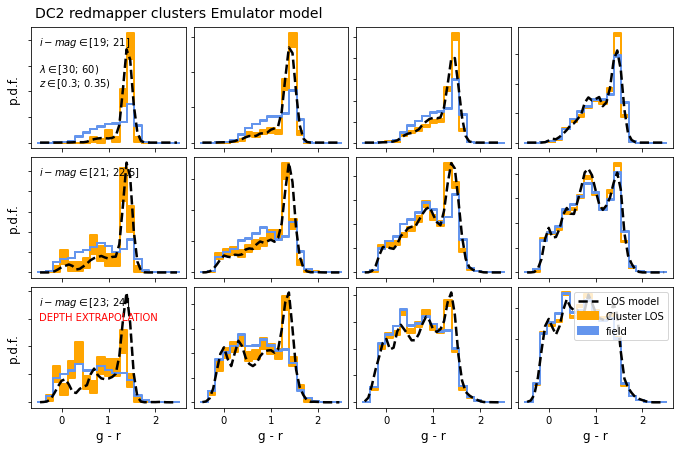

In [29]:
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(11.5, 7.), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.075, wspace=0.05)

bins_hist = np.linspace(-0.5, 2.5, 20)
cens_hist = bins_hist[:-1] + np.diff(bins_hist) / 2
bins_kde = np.linspace(-0.5, 2.5, 40)
cens = bins_kde[:-1] + np.diff(bins_kde) / 2

for ax in axarr[0]:
    ax.set_xticklabels([])
for ax in axarr[1]:
    ax.set_xticklabels([])    

for ax in axarr[:, 0]:
    ax.set_yticklabels([])
    
for ax in axarr[0, 1:]:
    ax.set_yticklabels([])
for ax in axarr[1, 1:]:
    ax.set_yticklabels([])
for ax in axarr[2, 1:]:
    ax.set_yticklabels([])    
        
for ax in axarr[2]:
    ax.set_xlabel("g - r", fontsize=12)
for ax in axarr[:, 0]:
    ax.set_ylabel("p.d.f.", fontsize=12)
    
col = "COLOR_G_R" 
magcol = "MAG_I"
rcol = "LOGR"

r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]

# ####################################################################################################
mag_lims = (19., 21.)
for rbin in np.arange(4):
    ax = axarr[0, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]


    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    

    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")    
    
# ####################################################################################################
mag_lims = (21., 22.5)
for rbin in np.arange(4):
    ax = axarr[1, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]

    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field") 
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")        

    
# ####################################################################################################
mag_lims = (23., 24)
for rbin in np.arange(4):
    ax = axarr[2, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]
   
    
    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")    

    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")     
    handles, labels = ax.get_legend_handles_labels()    

    
fs = 10

axarr[2, 3].legend(loc=1, fontsize=fs, handles=handles, labels=labels)    
# axarr[2, 2].legend(loc=1, fontsize=fs, handles=handles[3:], labels=labels[3:])  
    

# axarr[2, 0].text(0.05, 0.72, "Depth Extrapolation", transform=axarr[2, 0].transAxes, fontsize=fs)
axarr[0, 0].text(0.05, 0.63, "$\lambda\in[30;\,60)$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[0, 0].text(0.05, 0.51, "$z\in[0.3;\,0.35)$", transform=axarr[0, 0].transAxes, fontsize=fs)

axarr[0, 0].text(0.05, 0.85, "$i-mag\in[19;\, 21]$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[1, 0].text(0.05, 0.85, "$i-mag\in[21;\, 22.5]$", transform=axarr[1, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.85, "$i-mag\in[23;\, 24]$ ", transform=axarr[2, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.73, "Depth Extrapolation".upper(), transform=axarr[2, 0].transAxes, fontsize=fs, color="red")
fig.text(0.13, 0.9, "DC2 redmapper clusters Emulator model", fontsize=14)
# fig.savefig("DC2-ALPHA_LOWZ_decoupled_g-r-color_magnitude_slices_radial_v01.png", dpi=300, bbox_inches="tight")

<ipython-input-30-c682a167d2b7>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "1", "2", "3", ""])


Text(0.13, 0.9, 'DC2 redmapper clusters Emulator model')

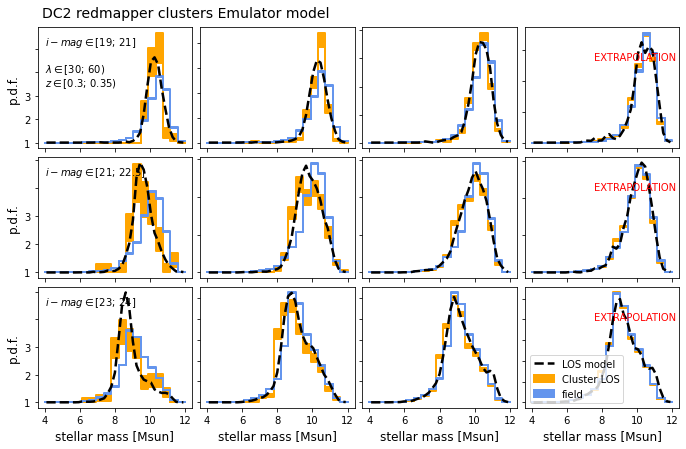

In [30]:
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(11.5, 7.), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.075, wspace=0.05)

bins_hist = np.linspace(4, 12, 20)
cens_hist = bins_hist[:-1] + np.diff(bins_hist) / 2
bins_kde = np.linspace(4, 12, 40)
cens = bins_kde[:-1] + np.diff(bins_kde) / 2

for ax in axarr[0]:
    ax.set_xticklabels([])
for ax in axarr[1]:
    ax.set_xticklabels([])    

for ax in axarr[:, 0]:
    ax.set_yticklabels(["0", "1", "2", "3", ""])
    
for ax in axarr[0, 1:]:
    ax.set_yticklabels([])
for ax in axarr[1, 1:]:
    ax.set_yticklabels([])
for ax in axarr[2, 1:]:
    ax.set_yticklabels([])    
        
for ax in axarr[2]:
    ax.set_xlabel("stellar mass [Msun]", fontsize=12)
for ax in axarr[:, 0]:
    ax.set_ylabel("p.d.f.", fontsize=12)
    
col = "STELLAR_MASS" 
magcol = "MAG_I"
rcol = "LOGR"

r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]

# ####################################################################################################
mag_lims = (19., 21.)
for rbin in np.arange(4):
    ax = axarr[0, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]
    
    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    

    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")         
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")    
    
# ####################################################################################################
mag_lims = (21., 22.5)
for rbin in np.arange(4):
    ax = axarr[1, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]

    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")        

    
# ####################################################################################################
mag_lims = (23., 24)
for rbin in np.arange(4):
    ax = axarr[2, rbin]

    r_lims = r_lims_all[rbin]
    sample = samples[rbin]
    csample = csamples[rbin]
    rsample = rsamples[rbin]
    
    
    ctab = _wide_cr_settings_clust["container"].data.copy()
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=2.5, label="LOS model")     
    handles, labels = ax.get_legend_handles_labels()    

    
fs = 10

axarr[2, 3].legend(loc=3, fontsize=fs, handles=handles, labels=labels)    
# axarr[2, 2].legend(loc=1, fontsize=fs, handles=handles[3:], labels=labels[3:])  
    

# axarr[2, 0].text(0.05, 0.72, "Depth Extrapolation", transform=axarr[2, 0].transAxes, fontsize=fs)
axarr[0, 0].text(0.05, 0.63, "$\lambda\in[30;\,60)$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[0, 0].text(0.05, 0.51, "$z\in[0.3;\,0.35)$", transform=axarr[0, 0].transAxes, fontsize=fs)

axarr[0, 0].text(0.05, 0.85, "$i-mag\in[19;\, 21]$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[1, 0].text(0.05, 0.85, "$i-mag\in[21;\, 22.5]$", transform=axarr[1, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.85, "$i-mag\in[23;\, 24]$ ", transform=axarr[2, 0].transAxes, fontsize=fs)
axarr[0, 3].text(0.45, 0.73, "Extrapolation".upper(), transform=axarr[0, 3].transAxes, fontsize=fs, color="red")
axarr[1, 3].text(0.45, 0.73, "Extrapolation".upper(), transform=axarr[1, 3].transAxes, fontsize=fs, color="red")
axarr[2, 3].text(0.45, 0.73, "Extrapolation".upper(), transform=axarr[2, 3].transAxes, fontsize=fs, color="red")
fig.text(0.13, 0.9, "DC2 redmapper clusters Emulator model", fontsize=14)
# fig.savefig("DC2-ALPHA_LOWZ_decoupled_size_magnitude_slices_radial_v01.png", dpi=300, bbox_inches="tight")
